## Prédiction de maladie sur les données cliniques 

In [1]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

Utilisation exclusive des données clininique

In [2]:
train_data_clinical = pd.read_csv("train-data_clinical.csv", sep = ";")
headers = ['label']
train_label = pd.read_csv("train-label.txt", names = headers)
train_label['label'].value_counts()

Healthy    4684
IBD         281
Name: label, dtype: int64

Nous voyons qu'il y'a moins de personnes malades que de personnes en bonne santé

In [3]:
train_data_clinical.head(3)

EXERCISE_FREQUENCY  SEX  ONE_LITER_OF_WATER_A_DAY_FREQUENCY  \
0                   2    0                                   4   
1                   0    1                                   3   
2                   2    1                                   3   

   SEAFOOD_FREQUENCY  PROBIOTIC_FREQUENCY  OLIVE_OIL  FRUIT_FREQUENCY  \
0                  2                    4          0                3   
1                  1                    0          3                2   
2                  2                    4          2                4   

   SLEEP_DURATION  SUGAR_SWEETENED_DRINK_FREQUENCY  MILK_CHEESE_FREQUENCY  \
0               4                                0                      0   
1               3                                1                      1   
2               5                                0                      1   

   RED_MEAT_FREQUENCY  MEAT_EGGS_FREQUENCY  VEGETABLE_FREQUENCY  
0                   3                    4                    3  
1                   1                    2                    2  
2                   1                    4                    4

Encodage des labels un utilisant le module labelbinazer de sklearn 

Décompostion du jeux de données d'entrainement à l'aide de train_test split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_data_clinical, train_label['label'], test_size = 0.3)

In [5]:
print("===== shape X_train =====")
print(X_train.shape)
print("===== shape X_test =====")
print(X_test.shape)

===== shape X_train =====
(3475, 13)
===== shape X_test =====
(1490, 13)


Encodage des labels par labelencoder

In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y_train_en = le.fit_transform(Y_train)
Y_test_en = le.transform(Y_test)
print("====== label training =======")
print(Y_train_en[:10])
print("====== label testing =======")
print(Y_test_en[:10])

====== label training =======
[0 0 0 0 0 1 0 0 0 0]
====== label testing =======
[0 0 0 0 0 0 0 1 0 0]


# Utilisation des modèles (Knn, Decision tree et svm)

## Knn

In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
knn_model = Pipeline([
    
    ('knn', KNeighborsClassifier())
])
param_grid = {
    'knn__n_neighbors':[1,3,5,7,9]
}
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(knn_model, param_grid, scoring = "roc_auc", cv = 5)

In [8]:
grid.fit(X_train, Y_train_en)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': [1, 3, 5, 7, 9]},
             scoring='roc_auc')

In [9]:
grid.best_score_

0.7049015009380863

Le modèle obtenu en faisant une cross validation de 5 fold sur le jeux de données d'entrainement nous donne un score de 70%, nous allons évalué ce modèle sur le jeux de données de test pour évaluer ces performances

In [10]:
Ypred_knn_proba = grid.predict_proba(X_test)[:,1]

In [11]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(Y_test_en, Ypred_knn_proba, pos_label= 1)

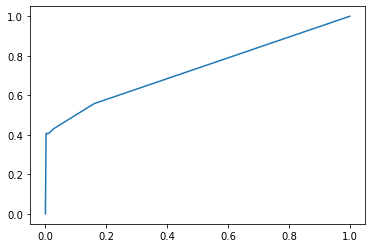

In [12]:
plt.plot(fpr, tpr)

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(Y_test_en, Ypred_knn_proba)

0.7308644735970318

## SVM kernel lineaire

In [14]:
from sklearn.svm import SVC
svm_model = SVC(probability = True)
C_grid = np.logspace(-3,3, 10)
gamma_grid = [0.1, 0.25, 0.5, 0.75, 1, 2]
svm_grid = [
    {'kernel' : ['linear'], 'C' : C_grid},
    {'kernel' : ['rbf'], 'C' : C_grid, 'gamma' : gamma_grid}
]
grid_search_svm = GridSearchCV(svm_model, svm_grid, scoring = "roc_auc", cv = 5)

In [15]:
grid_search_svm.fit(X_train, Y_train_en)

GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid=[{'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                          'kernel': ['linear']},
                         {'C': array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                          'gamma': [0.1, 0.25, 0.5, 0.75, 1, 2],
                          'kernel': ['rbf']}],
             scoring='roc_auc')

In [16]:
grid_search_svm.best_score_

0.7462320200125079

Avec un svm de kernel linéaire nous obtenons avec une cross validation un modèle de plus 94% d'accuracy

0.7586298283972703


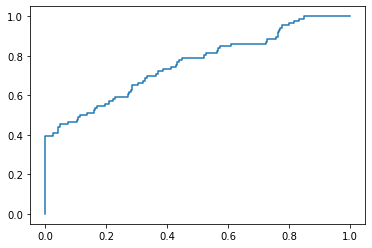

In [17]:
Ypred_svm = grid_search_svm.predict_proba(X_test)[:,1]
fpr_svm, tpr_svm, _svm = roc_curve(Y_test_en, Ypred_svm, pos_label= 1)
print(roc_auc_score(Y_test_en, Ypred_svm))
plt.plot(fpr_svm, tpr_svm)

## RandomForest

In [18]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf_grid = {
    'n_estimators':[100,200,300,400],
    'max_depth' : [3, 5, 7, 10]
}
grid_search_rf = GridSearchCV(rf, rf_grid, scoring = "roc_auc", cv = 5)

In [19]:
grid_search_rf.fit(X_train, Y_train_en)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 7, 10],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='roc_auc')

In [20]:
grid_search_rf.best_score_

0.7672764227642277

0.791293977340489


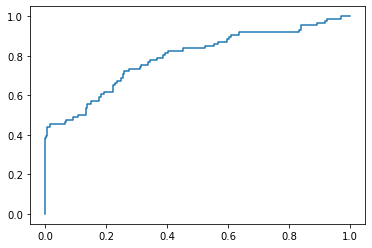

In [21]:
Ypred_rf = grid_search_rf.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, _rf = roc_curve(Y_test_en, Ypred_rf, pos_label= 1)
print(roc_auc_score(Y_test_en, Ypred_rf))
plt.plot(fpr_rf, tpr_rf)

   ## _Boosting_

In [22]:
from sklearn.ensemble import AdaBoostClassifier
a = AdaBoostClassifier ()
a.get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [23]:
from sklearn.ensemble import AdaBoostClassifier
ABC = AdaBoostClassifier () 

params = [{ 
    'n_estimators' : [e * 100 for e in range (1, 6)]
}]

grid_search = GridSearchCV (estimator = ABC,
                            param_grid = params,
                            cv = 5
                           
                           )

grid_search = grid_search.fit(X_train, Y_train_en)
grid_search.best_params_

{'n_estimators': 100}

In [24]:
grid_search.best_score_

0.9427338129496403

0.7320363744782349


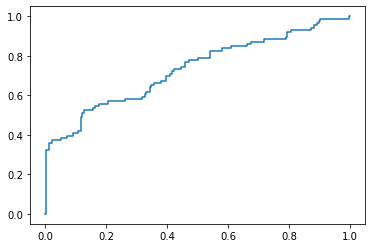

In [25]:
Ypred_ABC = grid_search.predict_proba(X_test)[:,1]
fpr_ABC, tpr_ABC, _ABC = roc_curve(Y_test_en, Ypred_ABC, pos_label= 1)
print(roc_auc_score(Y_test_en, Ypred_ABC))
plt.plot(fpr_ABC, tpr_ABC)

## Gradient Boosting

In [26]:
from xgboost import XGBClassifier
b = XGBClassifier ()
b.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'gpu_id', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])

In [27]:
from xgboost import XGBClassifier
import numpy as np

XGB = XGBClassifier () 

params = [{'gamma' : [e for e in range (1, 11)],
    'n_estimators' : [e * 100 for e in range (1, 6)],
           'learning_rate' : [e for e in np.arange (0.05, 1, 25/100)]
}]

grid_search = GridSearchCV (estimator = XGB,
                            param_grid = params,
                            cv = 5
                           
                           )

grid_search = grid_search.fit(X_train, Y_train_en)
grid_search.best_params_

{'gamma': 3, 'learning_rate': 0.05, 'n_estimators': 200}

0.7799021069369907


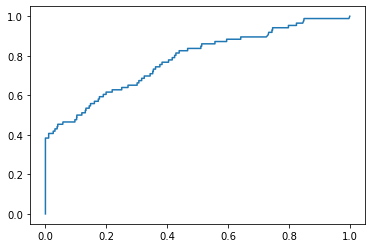

In [28]:
XGB = XGBClassifier ( learning_rate = 0.05,
                         gamma = 1, n_estimators = 100)
Ypred_XGB = grid_search.predict_proba(X_test)[:,1]
fpr_XGB, tpr_XGB, _XGB = roc_curve(Y_test_en, Ypred_XGB, pos_label= 1)
print(roc_auc_score(Y_test_en, Ypred_XGB))
plt.plot(fpr_XGB, tpr_XGB)

In [29]:
pd.DataFrame ({"AUC_KNN" : roc_auc_score(Y_test_en, Ypred_knn_proba), "AUC_SVM" : roc_auc_score(Y_test_en, Ypred_svm),
               "AUC_RandomF" : roc_auc_score(Y_test_en, Ypred_rf), 
               "AUC_AdaBoost" : roc_auc_score(Y_test_en, Ypred_ABC),
              "AUC_Gradientboost" : roc_auc_score(Y_test_en, Ypred_XGB)}, index = [0])

AUC_KNN  AUC_SVM  AUC_RandomF  AUC_AdaBoost  AUC_Gradientboost
0  0.730864  0.75863     0.791294      0.732036           0.779902

En considérant la classe IBD comme classe positive, l'analyse du tableau montre que le Random forest donne le meilleur score.    

Nous allons donc utiliser notre base de données test afin de prédire et convertir nos labels en text en utilisant le random forest.

In [32]:
data_test_clinical = pd.read_csv("test-data_clinical.csv", sep = ";")

In [34]:
Label_pred = grid_search_rf.predict(data_test_clinical)
print("=== Label prédit ===")
Label_pred[:10]

=== Label prédit ===


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [35]:
Label_predi = le.inverse_transform(Label_pred)
Label_predi[:100]

array(['Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy', 'Healthy',
       'Healthy', 'Healthy', 'Healthy', 'Healthy', 

In [36]:
np.savetxt("Label_predi.txt", Label_predi, fmt='%s')